In [2]:
import pandas as pd
import numpy as np
from numpy import random
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import albumentations as A
import time
from tqdm import tqdm

2024-06-03 06:24:01.785742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 06:24:01.785871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 06:24:01.924673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# limiter=int(input('Enter a value for the maximum number of images in a class'))
data_path=r'/kaggle/input/plant-disease-classification-merged-dataset'
classes=os.listdir(data_path)
filepaths=[]
labels=[]
for klass in classes:
    classpath=os.path.join(data_path, klass)
    flist=os.listdir(classpath)
#     if len(flist) > limiter:
#         flist=np.random.choice(flist, limiter, replace=False)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
num_of_classes=len(classes)
print(df['labels'].value_counts())


labels
Grape__black_rot                  11390
Soybean__healthy                   5998
Soybean__caterpillar               3309
Tomato__yellow_leaf_curl_virus     3214
Peach__bacterial_spot              2297
                                  ...  
Soybean__bacterial_blight            56
Coffee__cercospora_leaf_spot         55
Sugarcane__red_stripe                53
Soybean__downy_mildew                51
Soybean__mosaic_virus                22
Name: count, Length: 88, dtype: int64


In [4]:
classes = {i:j for i,j in enumerate(df['labels'].unique())}
classes

{0: 'Tomato__septoria_leaf_spot',
 1: 'Tea__anthracnose',
 2: 'Rice__hispa',
 3: 'Soybean__diabrotica_speciosa',
 4: 'Tomato__healthy',
 5: 'Gauva__diseased',
 6: 'Wheat__yellow_rust',
 7: 'Soybean__downy_mildew',
 8: 'Pomegranate__diseased',
 9: 'Apple__rust',
 10: 'Tea__algal_leaf',
 11: 'Pomegranate__healthy',
 12: 'Tomato__early_blight',
 13: 'Peach__bacterial_spot',
 14: 'Soybean__healthy',
 15: 'Potato__healthy',
 16: 'Cherry__healthy',
 17: 'Apple__healthy',
 18: 'Rice__neck_blast',
 19: 'Wheat__septoria',
 20: 'Jamun__healthy',
 21: 'Strawberry___leaf_scorch',
 22: 'Coffee__rust',
 23: 'Mango__healthy',
 24: 'Mango__diseased',
 25: 'Apple__black_rot',
 26: 'Soybean__powdery_mildew',
 27: 'Lemon__healthy',
 28: 'Pepper_bell__healthy',
 29: 'Strawberry__healthy',
 30: 'Cassava__healthy',
 31: 'Corn__healthy',
 32: 'Jamun__diseased',
 33: 'Corn__common_rust',
 34: 'Tomato__yellow_leaf_curl_virus',
 35: 'Coffee__cercospora_leaf_spot',
 36: 'Grape__black_measles',
 37: 'Rice__health

In [5]:
# tf.image.resize_with_crop_or_pad(
#     image, target_height, target_width
# )

Each image has shape: (256, 256, 3) ,dtype: float32, class of: Grape__black_rot


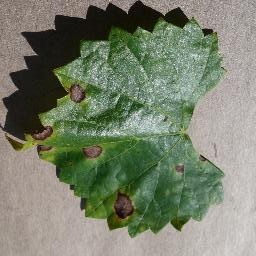

In [6]:
from tensorflow.keras.utils import img_to_array, load_img
# Load random smaple of plant disease 
random_sample = df.sample(n=1).iloc[0]
sample_image_path = random_sample['filepaths']
sample_image = load_img(sample_image_path)

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape} ,dtype: {sample_array.dtype}, class of: {random_sample['labels']}")
sample_image

In [7]:
train_df, test_df=train_test_split(df, train_size=.8, shuffle=True, stratify=df['labels'])
print(f'train_df lngth= {len(train_df)},  test_df length= {len(test_df)}')
total_train=train_df['labels'].value_counts()
print(f'the train_set contain {num_of_classes} class, total train each class is:\n {total_train}')

train_df lngth= 63269,  test_df length= 15818
the train_set contain 88 class, total train each class is:
 labels
Grape__black_rot                  9112
Soybean__healthy                  4798
Soybean__caterpillar              2647
Tomato__yellow_leaf_curl_virus    2571
Peach__bacterial_spot             1837
                                  ... 
Soybean__bacterial_blight           45
Coffee__cercospora_leaf_spot        44
Sugarcane__red_stripe               42
Soybean__downy_mildew               41
Soybean__mosaic_virus               18
Name: count, Length: 88, dtype: int64


In [8]:
total_test=test_df['labels'].value_counts()
print(f'the test_set contain {num_of_classes} class, total test each class is:\n {total_test}')

the test_set contain 88 class, total test each class is:
 labels
Grape__black_rot                  2278
Soybean__healthy                  1200
Soybean__caterpillar               662
Tomato__yellow_leaf_curl_virus     643
Peach__bacterial_spot              460
                                  ... 
Soybean__bacterial_blight           11
Coffee__cercospora_leaf_spot        11
Sugarcane__red_stripe               11
Soybean__downy_mildew               10
Soybean__mosaic_virus                4
Name: count, Length: 88, dtype: int64


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 63268 validated image filenames belonging to 88 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 15818 validated image filenames belonging to 88 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(88, activation='softmax')
  ])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=80,
    epochs=40,
    validation_data=test_generator,
    validation_steps=20,
    verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.1415 - loss: 4.0059 - val_accuracy: 0.2891 - val_loss: 3.0817
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.2703 - loss: 3.0961 - val_accuracy: 0.2859 - val_loss: 2.8231
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.3159 - loss: 2.6677 - val_accuracy: 0.4109 - val_loss: 2.4356
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.3988 - loss: 2.2956 - val_accuracy: 0.4766 - val_loss: 1.8582
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.4381 - loss: 2.1213 - val_accuracy: 0.4766 - val_loss: 1.8270
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4800 - loss: 1.8696 - val_accuracy: 0.5719 - val_loss: 1.6177
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5243 - loss: 1.6525 - val_accuracy: 0.6141 - val_loss: 1.4158
Epoch 8/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5620 - loss: 1.5155 - val_accuracy: 0.6172 - val_loss: 1.

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7090 - loss: 0.9399 - val_accuracy: 0.7096 - val_loss: 0.9959
Epoch 26/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7191 - loss: 0.9547 - val_accuracy: 0.6406 - val_loss: 1.1780
Epoch 27/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7001 - loss: 0.9397 - val_accuracy: 0.7156 - val_loss: 0.8519
Epoch 28/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.7446 - loss: 0.8097 - val_accuracy: 0.7094 - val_loss: 0.9420
Epoch 29/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.7227 - loss: 0.9093 - val_accuracy: 0.7328 - val_loss: 0.8720
Epoch 30/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7090 - loss: 0.9469 - val_accuracy: 0.7203 - val_loss: 0.9594
Epoch 31/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7377 - loss: 0.7917 - val_accuracy: 0.6719 - val_loss: 1.0775
Epoch 32/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7141 - loss: 0.8744 - val_accuracy: 0.7641 - val_lo